In [4]:
import requests

In [5]:
r = requests.get('http://www.citibikenyc.com/stations/json')

In [6]:
type(r)

requests.models.Response

SyntaxError: invalid syntax (<ipython-input-7-ea092d2967a4>, line 1)

In [66]:
# r.text

In [67]:
# r.json()

In [10]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [11]:
r.json()['executionTime']

u'2015-07-13 08:21:10 PM'

In [12]:
# Number of citi bike stations
len(r.json()['stationBeanList'])

329

In [13]:
# Create a list of all keys in stationBeanList
key_list = []
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)

In [14]:
key_list

[u'availableDocks',
 u'totalDocks',
 u'city',
 u'altitude',
 u'stAddress2',
 u'longitude',
 u'lastCommunicationTime',
 u'postalCode',
 u'statusValue',
 u'testStation',
 u'stAddress1',
 u'stationName',
 u'landMark',
 u'latitude',
 u'statusKey',
 u'availableBikes',
 u'id',
 u'location']

In [15]:
# Import the data into a dataframe
from pandas.io.json import json_normalize
df = json_normalize(r.json()['stationBeanList'])

In [16]:
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,23,15,,72,,2015-07-13 08:20:26 PM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
1,,0,31,,79,,2015-07-13 08:20:15 PM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
2,,18,9,,82,,2015-07-13 08:19:36 PM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27
3,,50,7,,83,,2015-07-13 08:18:50 PM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
4,,31,7,,116,,2015-07-13 08:20:12 PM,40.741776,,-74.001497,,W 17 St & 8 Ave,,W 17 St & 8 Ave,1,In Service,False,39


<function matplotlib.pyplot.show>

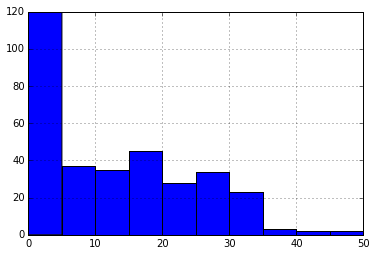

In [17]:
# Check the range of values, starting with available bikes
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
df['availableBikes'].hist()
plt.show

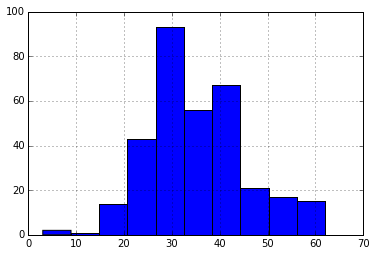

In [18]:
df['totalDocks'].hist()

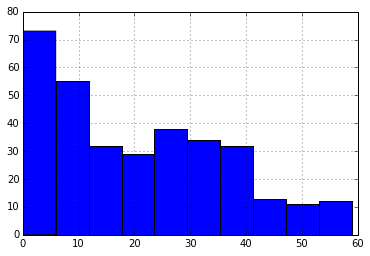

In [19]:
df['availableDocks'].hist()

In [21]:
# Make a plot that shows the percent available of each dock
avail = df['availableBikes']

In [22]:
total = df['totalDocks']

In [23]:
df2 = avail / total

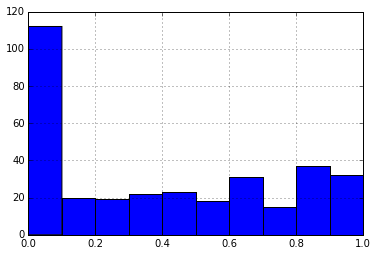

In [25]:
df2.hist()

In [26]:
df['availableBikes'].max()

50

Exercises

In [38]:
# Are there any test stations?
testStations = []
for index, row in df.iterrows():
    if row['testStation'] == True:
        testStations.append(index)

In [40]:
testStations

[]

In [41]:
# There are no test stations

In [47]:
# How many are in service?
inService = 0
for index, row in df.iterrows():
    if row['statusValue'] == 'In Service':
        inService += 1
        

In [48]:
inService

326

In [50]:
# A better way of doing what I just did
df.groupby('statusValue').size()

statusValue
In Service        326
Not In Service      3
dtype: int64

In [51]:
df.groupby('statusKey').size()

statusKey
1            326
3              3
dtype: int64

In [52]:
# What is statusKey?

In [54]:
# What is the mean number of bikes in a dock?
df['availableBikes'].mean()

12.699088145896656

In [55]:
# What is the median?
df['availableBikes'].median()

11.0

In [56]:
# How does this change if we remove the docs that are not in service?

In [58]:
df2 = df[df.statusValue == 'In Service']

In [59]:
df2['availableBikes'].mean()

12.815950920245399

In [60]:
df2['availableBikes'].median()

11.0

In [61]:
len(df2)

326

In [62]:
len(df)

329

In [63]:
# A better way to do what I just did
df[df['statusValue'] == 'In Service']['availableBikes'].median()

11.0

In [68]:
import sqlite3 as lite
con = lite.connect('./db/citi_bike.db')
cur = con.cursor()
with con:
    cur.execute('CREATE TABLE citibike_reference (id INT PRIMARY KEY, totalDocks INT, city TEXT, altitude INT, stAddress2 TEXT, longitude NUMERIC, postalCode TEXT, testStation TEXT, stAddress1 TEXT, stationName TEXT, landMark TEXT, latitude NUMERIC, location TEXT )')

In [72]:
#a prepared SQL statement we're going to execute over and over again
sql = "INSERT INTO citibike_reference (id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)"

#for loop to populate values in the database
with con:
    for station in r.json()['stationBeanList']:
        #id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location)
        cur.execute(sql,(station['id'],station['totalDocks'],station['city'],station['altitude'],station['stAddress2'],station['longitude'],station['postalCode'],station['testStation'],station['stAddress1'],station['stationName'],station['landMark'],station['latitude'],station['location']))

In [73]:
# Extract the column from the DataFrame and put them into a list
station_ids = df['id'].tolist()

In [75]:
# add the '_' to the station name and also add the data type for SQLite
station_ids = ('_' + str(x) + ' INT' for x in station_ids)

In [79]:
# create the table
with con: 
    cur.execute("CREATE TABLE available_bikes ( execution_time INT, " +  ", ".join(station_ids) + ");")

In [80]:
# a package with datetime objects
import time

# a package for parsing a string into a Python datetime object
from dateutil.parser import parse

import collections

# take the string and parse it in to a Python datetime object
exec_time = parse(r.json()['executionTime'])

In [104]:
with con:
    cur.execute("INSERT INTO available_bikes (execution_time) VALUES (?)", (exec_time.strftime('%S'),))

In [105]:
id_bikes = collections.defaultdict(int) #defaultdict to store bikes by station

# loop through the stations in the station list
for station in r.json()['stationBeanList']:
    id_bikes[station['id']] = station['availableBikes']

In [106]:
# iterate through the defaultdict to update the values in the database
with con:
    for k, v in id_bikes.iteritems():
        cur.execute("UPDATE available_bikes SET _" + str(k) + " = " + str(v) + " WHERE execution_time = " + exec_time.strftime('%S') + ";")

In [107]:
# Turn this in to a script (requests.get(........)